### KNN Regression Model with RF + RFECV Feature Selection

In [1]:
import re
import os
import joblib
import argparse
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Check current working directory for workspace
os.getcwd()

'/home/rc/capstone/notebooks/model-train-tests'

In [2]:
# Define output directory
out_dir = Path("../../knn_test") 

# Set cwd for workspace (load knn model framework) and knn model outputs
# os.chdir('../../knn_test')

# Load the serialized objects (verify framework paths for loading in the model)
final_model = joblib.load(out_dir / 'knn_final_model.joblib')
preprocessor = joblib.load(out_dir / 'preprocessor.joblib')
selector = joblib.load(out_dir / 'rfecv_selector.joblib')

In [4]:
# set file paths
os.chdir('../../data')

# Load new data
df_new = pd.read_csv("Key_indicator_districtwise.csv")

# Features prefix cleaning:
# os.chdir('../knn_test/test')

# Define your ID columns and target
id_cols = ['State_Name', 'State_District_Name'] 
target_col = 'Infant_Mortality_Rate_Imr_Total_Person'           

# Remove prefix feature column names
df_new.columns = [re.sub(r'^[A-Z]{2}_', '', col) for col in df_new.columns]
id_cols_fixed = [re.sub(r'^[A-Z]{2}_', '', col) for col in id_cols]

# Drop ID columns and target if present
drop_cols = id_cols_fixed + ([target_col] if target_col in df_new.columns else [])
X_new = df_new.drop(columns=drop_cols, errors='ignore')

# Apply preprocessor
X_new_processed = preprocessor.transform(X_new)

# Apply feature selector
X_new_selected = selector.transform(X_new_processed)

# Predict with final model
y_new_pred = final_model.predict(X_new_selected)

/home/rc/capstone/venv/lib/python3.12/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['Total_Fertility_Rate_Rural' 'Total_Fertility_Rate_Urban']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [5]:
# test knn predictions
print(y_new_pred)

[43.         48.         53.         70.         37.         67.9417745
 49.94815013 53.         56.         52.65976149 48.69963726 39.
 60.         65.         74.         46.24972656 63.26190762 62.
 58.         52.31224112 56.         61.         49.1663285  52.
 40.24254332 43.42638832 40.         49.         41.         48.
 43.98639714 49.         46.         48.23577854 47.         48.
 52.         62.54683898 56.         45.         64.         48.
 44.08758592 55.         47.         45.85780693 45.6224819  31.
 48.         53.         44.         55.         49.         49.
 51.         43.         64.83577018 43.         58.         40.
 39.57346375 38.39       43.99       47.2        34.93       46.14
 55.41579665 45.72       56.71491226 48.14       51.82       57.25
 55.         44.83572814 48.78       51.53397047 28.         41.84915598
 31.         28.14528424 45.         33.         28.17401395 54.
 45.         29.         27.08951919 53.         52.         40.
 54.74

In [10]:
# Check numpy array dimensions
y_new_pred.shape

(284,)

In [6]:
# If working with new batch prediction
# y_test: true labels for test set
# y_pred: predictions from model

# Load in knn model train/test pipeline
X_train_selected = np.load('X_train_selected.npy')
y_train = np.load('y_train.npy')

# Or if stored as CSV
X_train_selected = pd.read_csv('X_train_selected.csv').values
y_train = pd.read_csv('y_train.csv').values.ravel()  # flatten if needed

if target_col in df_new.columns:
    y_test = df_new[target_col].values 
else:
    y_test = None  

# Test knn regression model predictions:
y_pred = final_model.predict(X_new_selected)

# Now the metrics calculation works:
if y_test is not None:
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_new_selected.shape[1]
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1) if n > p + 1 else None
else:
    print("No ground truth values found for evaluation.")

In [7]:
r2

0.9965852154865098

In [9]:
mae

0.2749370968902683

In [10]:
adj_r2

0.9964730510316872

In [ ]:
# Training metrics
y_train_pred = final_model.predict(X_train_selected)
n_tr = len(y_train)
p_tr = X_train_selected.shape[1]
train_metrics = {
    'R2': r2_score(y_train, y_train_pred),
    'Adjusted R2': 1 - (1 - r2_score(y_train, y_train_pred)) * (n_tr - 1) / (n_tr - p_tr - 1) if n_tr > p_tr + 1 else None,
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MAE': mean_absolute_error(y_train, y_train_pred)
}

# Test metrics
y_test_pred = final_model.predict(X_test_selected)
n_te = len(y_test)
p_te = X_test_selected.shape[1]
test_metrics = {
    'R2': r2_score(y_test, y_test_pred),
    'Adjusted R2': 1 - (1 - r2_score(y_test, y_test_pred)) * (n_te - 1) / (n_te - p_te - 1) if n_te > p_te + 1 else None,
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred)
}

In [ ]:
# Save model performance metrics
import json
with open('metrics.json', 'w') as f:
    json.dump(metrics, f)

In [ ]:
# Training set
plot_true_vs_pred(y_train, y_train_pred, out_dir, 'Training', train_metrics)

In [ ]:
# Test set
plot_true_vs_pred(y_test, y_test_pred, out_dir, 'Testing', test_metrics)

/home/rc/venvs/jupyter/lib/python3.12/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['Total_Fertility_Rate_Rural' 'Total_Fertility_Rate_Urban']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Text(0, 0.5, 'Importance')

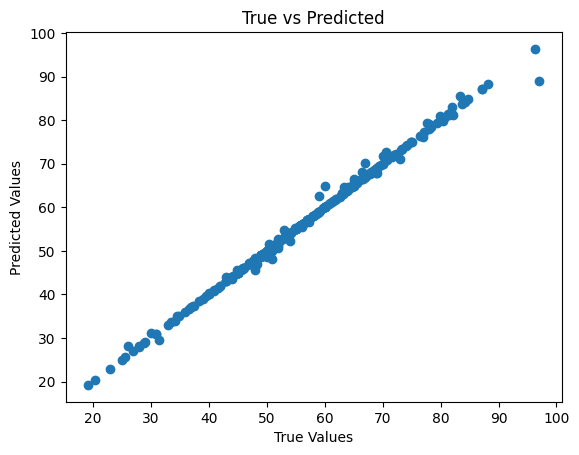

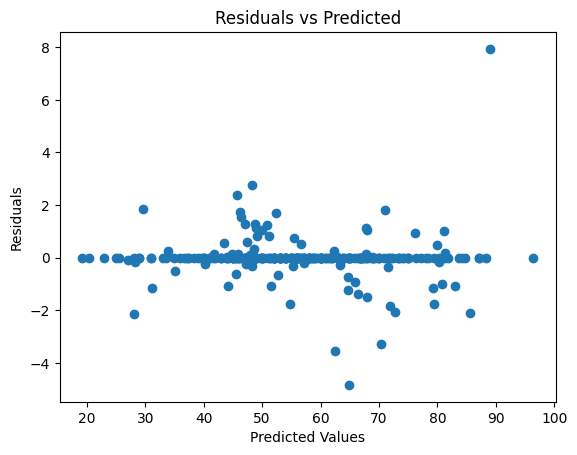

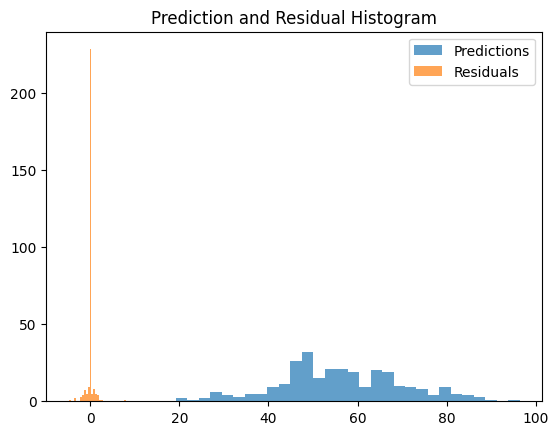

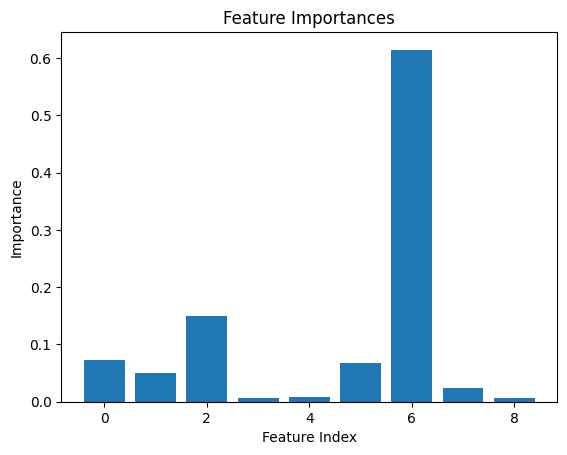

In [17]:
# Preprocessing and prediction
X_new_processed = preprocessor.transform(X_new)
X_new_selected = selector.transform(X_new_processed)
y_pred = final_model.predict(X_new_selected)

# True-predicted scatter
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True Values"); plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

# Residual plot
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

# Histogram
plt.figure()
plt.hist(y_pred, bins=30, alpha=0.7, label='Predictions')
plt.hist(residuals, bins=30, alpha=0.7, label='Residuals')
plt.legend()
plt.title("Prediction and Residual Histogram")

# Feature importances (if selector uses tree-based model)
importances = selector.estimator_.feature_importances_
plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")
plt.xlabel("Feature Index"); plt.ylabel("Importance")